In [ ]:
# 데이터 다운로드

mnist_dataset = torchvision.datasets.CelebA(root='/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3', download=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
import torchvision.datasets

import h5py
import numpy
import matplotlib.pyplot as plt
import h5py
import zipfile
import imageio
import os

# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [ ]:
# %%time

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = '/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3/celeba/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

OSError: ignored

In [ ]:
# check if CUDA is available
# if yes, set default tensor type to cuda
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# open HDF5 file and list any groups
with h5py.File('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3/celeba_aligned_small.h5py','r') as file_object:
  for group in file_object:
    print(group)
    pass

img_align_celeba


# New section

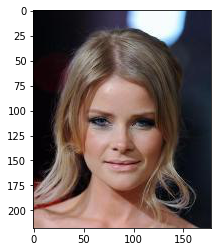

In [ ]:
with h5py.File('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3/celeba_aligned_small.h5py','r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['9.jpg'])
  plt.imshow(image, interpolation = 'none')
  pass

In [ ]:
# shape of the image array
image.shape

(218, 178, 3)

In [ ]:
# dataset class

class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

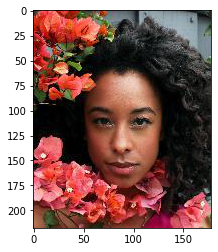

In [ ]:
celeba_dataset = CelebADataset('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/celeba_dataset3/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

In [ ]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


AssertionError: ignored